# Autoplay CartPole
---
Welcome to this notebook file where we will explore the use of reinforcement learning to play CartPole, an exciting and challenging game that requires balancing a pole on top of a cart. In this repository, we will be using the Proximal Policy Optimization (PPO) algorithm, an effective approach for training agents in complex environments, to accomplish this task.

The Autoplay feature will enable us to observe the trained agent's performance in real-time as it learns to master the game of CartPole. We will be using the OpenAI gym CartPole dataset to create the game environment, and the Ray library will provide us with the necessary tools to build and train our agent.

By the end of this notebook, you will have a better understanding of reinforcement learning, how it can be applied to solve challenging problems such as CartPole, and how to use PPO to train agents in similar environments. So let's dive in and see what we can achieve!

## Installing required packages


In [ ]:
!pip install -U "ray[tune]"  # installs Ray + dependencies for Ray Tune
!pip install -U "ray[rllib]"  # installs Ray + dependencies for Ray RLlib

## Importing relevant libraries

In [35]:
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.registry import register_env
import matplotlib.pyplot as plt
import gym
%matplotlib inline
from IPython import display

## Proximal Policy Optimization

### Configurations

In [23]:
config = {
"env": "CartPole-v1", # The environment to use
"num_gpus": 0, # The number of GPUs to use
"num_workers": 2, # The number of workers to use
"framework": "tf", # The deep learning framework to use
"model": {
"fcnet_hiddens": [256, 256] # The sizes of the hidden layers in the neural network
},
"lr": 0.0001, # The learning rate of the optimizer
"num_sgd_iter": 10, # The number of iterations of the optimizer to use
"gamma": 0.99, # The discount factor for future rewards
"use_gae": True, # Whether to use generalized advantage estimation
"lambda": 0.95, # The lambda parameter for generalized advantage estimation
"kl_coeff": 0.2, # The coefficient for the KL divergence in the loss function
"clip_rewards": True, # Whether to clip rewards to [-1, 1]
"clip_param": 0.3, # The clipping parameter for the PPO loss function
"vf_clip_param": 10.0, # The maximum value of the value function
"entropy_coeff": 0.01, # The coefficient for the entropy bonus in the loss function
"train_batch_size": 2000, # The size of the training batch
"sgd_minibatch_size": 128, # The size of the minibatch for each iteration of the optimizer
"rollout_fragment_length": 200, # The length of each rollout
"num_envs_per_worker": 5, # The number of environments to run in parallel on each worker
"batch_mode": "truncate_episodes", # Whether to truncate episodes at the end of a batch
"observation_filter": "NoFilter", # The filter to apply to observations
"vf_share_layers": True # Whether to share layers between the policy and value networks
}


### Training

In [ ]:
# Create a PPOTrainer with the specified configuration
trainer = PPOTrainer(config=config)

In [ ]:
# Train the agent for number of iterations (num_itr) and record the rewards
from ray.tune.logger import pretty_print
rewards = []
num_itr = 20
for i in range(num_itr):
    # Train the agent for one iteration and record the average reward
    result = trainer.train()
    rewards.append(result["episode_reward_mean"])
    # Print the result of the training iteration
    print(f'Iteration {i}: {result}')
    #print(pretty_print(result))


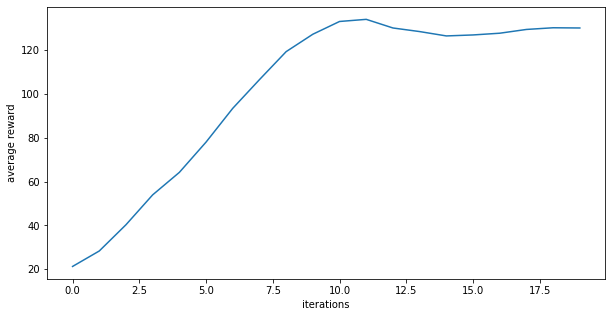

In [28]:
# Plot the mean training rewards across iterations
plt.figure(figsize=(10,5))
plt.plot(rewards)
plt.xlabel("iterations")
plt.ylabel("average reward")
plt.show()

## Saving the model

In [29]:
# Save the trained agent to a checkpoint file
trainer.save('cartpole')


'cartpole/checkpoint_000020'

## Restoring the model

In [11]:
# Restore the trained agent from a saved checkpoint file
trainer.restore('/content/cartpole/checkpoint_000002')


2023-03-25 10:32:25,902	INFO trainable.py:791 -- Restored on 172.28.0.12 from checkpoint: /content/cartpole/checkpoint_000002
2023-03-25 10:32:25,908	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 7.339240789413452, '_episodes_total': 138}


## Hyperparameters Tunning

In [ ]:
config = {
"env": "CartPole-v1", # the environment to train on
"framework": "tf", # the deep learning framework to use
"num_workers": 1, # the number of workers (CPU cores) to use for training
"num_gpus": 0, # the number of GPUs to use for training
"num_cpus_per_worker": 1, # the number of CPUs to assign to each worker
"lr": tune.grid_search([0.001, 0.01, 0.1]), # the learning rate to use for training
"log_level": "INFO", # the logging level for output
"model": { # the neural network model configuration
"fcnet_activation": "tanh", # the activation function to use for fully connected layers
"fcnet_hiddens": [256, 256], # the number of neurons in each fully connected layer
},
}

analysis = tune.run(
PPOTrainer,
config=config,
stop={"training_iteration": 3}, # stop training after 3 iterations
checkpoint_at_end=True, # save the final model checkpoint
verbose=1, # print verbose output during training
name="CartPole-v1_PPO", # the name of the training run
metric="episode_reward_mean", # the metric to track during training
mode="max", # whether to maximize or minimize the tracked metric
num_samples=3 # the number of hyperparameter configurations to try
)


In [ ]:
best_trial = analysis.get_best_trial("episode_reward_mean", "max", "last")
print("Best trial config: ", best_trial.config)
print("Best trial reward: ", best_trial.last_result["episode_reward_mean"])

## Auto Play Game - Using Trained Model

Total reward: 64.0


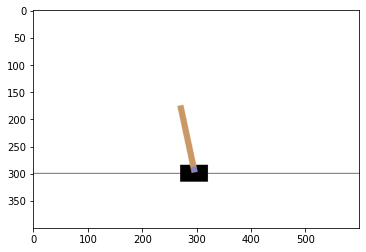

In [63]:
# Shutdown Ray if it was already running, and then initialize it
ray.shutdown()
ray.init()

# Define the environment name
env_name = "CartPole-v1"

# Create a PPO trainer object
trainer = PPOTrainer(config=DEFAULT_CONFIG, env=env_name)

# Load the trained checkpoint
checkpoint_path = "/content/cartpole/checkpoint_000002"
trainer.restore(checkpoint_path)

# Create an environment to test the policy
env = gym.make(env_name)

# Run the game using the trained policy
done = False
obs = env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
total_reward = 0
while not done:
    action = trainer.compute_action(obs)
    obs, reward, done, info = env.step(action)
    img.set_data(env.render('rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    total_reward += reward

print(f'Total reward: {total_reward}')
env.close()
ray.shutdown()


## Summary and Conclusion
In this notebook, we explored the use of reinforcement learning to play CartPole using the PPO algorithm. We used the OpenAI gym CartPole dataset to create the game environment and the Ray library to build and train our agent. The Autoplay feature allowed us to observe the agent's performance in real-time as it learned to master the game.

Reinforcement learning is a powerful technique for training agents to solve complex problems. In this notebook, we demonstrated how it can be used to play the game of CartPole using the PPO algorithm. The Autoplay feature enabled us to observe the agent's progress in real-time, providing us with valuable insights into its learning process.

While this notebook focused on CartPole, the techniques and tools demonstrated here can be applied to a wide range of other environments and problems. With further research and development, reinforcement learning has the potential to revolutionize many fields, from robotics to finance.

Overall, this notebook provides a valuable introduction to reinforcement learning and demonstrates the exciting possibilities it holds for the future of artificial intelligence.